<a href="https://colab.research.google.com/github/gh0st-kid/TimeSerieseProject/blob/main/TS_model_Holt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.metrics import (mean_squared_error, mean_absolute_error,
                             mean_absolute_percentage_error, r2_score,
                             accuracy_score, classification_report,
                             confusion_matrix)
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing, Holt
import warnings
import logging

In [2]:
warnings.filterwarnings("ignore")
logging.getLogger('prophet').setLevel(logging.ERROR)
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)

In [3]:
def check_versions():
  print(f'Pandas версия: {pd.__version__}')
  print(f'Numpy версия: {np.__version__}')
  print(f'Matplotlib версия: {plt.matplotlib.__version__}')
  print(f'Seaborn версия: {sns.__version__}')
  print(f'Scikit-learn версия: {sklearn.__version__}')
  print(f'Statsmodels версия: {sm.__version__}')
  print(f'Библиотеки успешно импортированы.')

check_versions()

Pandas версия: 2.1.4
Numpy версия: 1.26.4
Matplotlib версия: 3.7.1
Seaborn версия: 0.13.1
Scikit-learn версия: 1.5.2
Statsmodels версия: 0.14.3
Библиотеки успешно импортированы.


In [4]:
def load_and_prepare_data(file_path):
  """
  Загружает и подготавливает данные из CSV файла.

  Аргументы:
  file_path : str
      Путь к CSV файлу с данными.

  Возвращает:
  pandas.DataFrame
      Подготовленный датафрейм с данными, где:
    - Удалены пробелы из названий столбцов.
    - Столбец 'year' преобразован в формат даты и установлен в качестве индекса.
    - Все числовые столбцы преобразованы в тип float.
    - Данные отсортированы по году.
  """
  df = pd.read_csv(file_path, delimiter=';')
  df.columns = df.columns.str.strip()
  df['year'] = pd.to_datetime(df['year'], format='%Y') + pd.offsets.YearEnd(0)
  numeric_columns = df.columns[1:]
  df[numeric_columns] = df[numeric_columns].astype(float)
  df.sort_values('year', inplace=True)
  df.set_index('year', inplace=True)
  return df

df = load_and_prepare_data('/content/Data_new.csv')

In [5]:
df.head()

,zan(cfo),zan(szfo),zan(ufo),zan(skfo),zan(pfo),zan(uralfo),zan(sfo),zan(dfo),bezr(cfo),bezr(szfo),...,bezr(sfo),bezr(dfo),srd(cfo),srd(szfo),srd(ufo),srd(skfo),srd(pfo),srd(uralfo),srd(sfo),srd(dfo)
year,,,,,,,,,,,,,,,,,,,,,
2000-12-31,18014.45,6684.28,5850.76,2603.97,14242.84,5720.02,7933.75,4020.35,1516.38,710.35,...,1124.00,628.32,3231.0,2269.0,1592.0,1130.0,1726.0,2744.0,1933.0,2498.0
2001-12-31,18209.86,6788.93,5846.68,2653.35,14225.29,5642.28,7817.38,3939.14,1165.34,556.96,...,929.68,521.56,4300.0,3084.0,2165.0,1441.0,2319.0,3820.0,2576.0,3304.0
2002-12-31,18596.99,6911.31,6071.07,2762.83,14457.40,5733.71,8054.44,4071.13,1000.25,460.45,...,868.63,435.51,5436.0,4010.0,2898.0,1922.0,3035.0,4791.0,3373.0,4391.0
2003-12-31,18609.92,6873.34,5816.19,2765.72,14280.29,5974.66,7972.59,4046.69,1002.11,516.25,...,972.79,455.21,7211.0,5403.0,3747.0,2532.0,3917.0,6110.0,4351.0,5788.0
2004-12-31,18912.54,6970.38,6156.19,2769.92,14378.12,5938.58,8179.20,4013.68,930.45,443.38,...,853.29,442.81,8992.0,6938.0,4565.0,3466.0,4787.0,7413.0,5267.0,7047.0


In [6]:
def find_optimal_parameters(df, variable_name):
    """
    Находит оптимальные параметры для модели экспоненциального сглаживания с использованием метода наименьших квадратов (MSE).

    Аргументы:
        df : pandas.DataFrame
            Исходный датафрейм, содержащий временные ряды.
        variable_name : str
            Название переменной (столбца) в датафрейме df для анализа.

    Возвращает:
        tuple
            Кортеж, содержащий оптимальные параметры smoothing_level и smoothing_slope.
    """
    # Задаем диапазон значений для параметров
    smoothing_level_range = np.arange(0.1, 0.91, 0.1)
    smoothing_slope_range = np.arange(0.1, 0.91, 0.1)

    # Инициализация минимальной ошибки
    min_rmse = np.inf

    for smoothing_level in smoothing_level_range:
        for smoothing_slope in smoothing_slope_range:
            # Подгонка модели с текущими параметрами
            model_double_exp_smoothing = Holt(df[variable_name], exponential=True).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing_slope)
            forecast_double_exp_smoothing = model_double_exp_smoothing.fittedvalues
            rmse = np.sqrt(mean_squared_error(df[variable_name], forecast_double_exp_smoothing))

            # Обновление минимальной ошибки и оптимальных параметров
            if rmse < min_rmse:
                min_rmse = rmse
                optimal_smoothing_level = smoothing_level
                optimal_smoothing_slope = smoothing_slope

    # Вывод оптимальных параметров и RMSE
    print('Оптимальные параметры smoothing_level:', optimal_smoothing_level)
    print('Оптимальные параметры smoothing_slope:', optimal_smoothing_slope)
    print('Минимальная RMSE:', min_rmse)

    return optimal_smoothing_level, optimal_smoothing_slope

In [7]:
find_optimal_parameters(df, 'srd(cfo)')

Оптимальные параметры smoothing_level: 0.7000000000000001
Оптимальные параметры smoothing_slope: 0.9
Минимальная RMSE: 1255.78136607734


(0.7000000000000001, 0.9)

In [8]:
def split_train_test_by_ratio(df, variable_name, train_size=0.7):
    """
    Делит временной ряд на обучающую и тестовую выборки по указанному соотношению.

    Аргументы:
        df : pandas.DataFrame
            Исходный датафрейм, содержащий временной ряд.
        variable_name : str
            Название переменной (столбца) в датафрейме df для анализа.
        train_size : float, optional
            Доля данных для обучения (по умолчанию 0.7).

    Возвращает:
        tuple
            Кортеж, содержащий обучающую (train) и тестовую (test) выборки в виде pandas.Series.
    """
    split_index = int(len(df) * train_size)
    train = df.iloc[:split_index][variable_name]
    test = df.iloc[split_index:][variable_name]
    return train, test

In [9]:
def train_double_exponential_smoothing(train, smoothing_level=0.7, smoothing_slope=0.9):
    """
    Обучает модель двойного экспоненциального сглаживания на обучающей выборке.

    Аргументы:
        train : pandas.Series
            Обучающая выборка временного ряда.
        smoothing_level : float, optional
            Уровень сглаживания. По умолчанию 0.7.
        smoothing_slope : float, optional
            Сглаживание тренда. По умолчанию 0.9.

    Возвращает:
        HoltWintersResults
            Обученная модель двойного экспоненциального сглаживания.
    """
    model = Holt(train, exponential=True).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing_slope)
    return model

In [10]:
def forecast_double_exponential_smoothing(train, test, smoothing_level=0.7, smoothing_slope=0.9, future_periods=3):
    """
    Прогнозирует значения временного ряда с использованием модели двойного экспоненциального сглаживания.

    Аргументы:
        train : pandas.Series
            Обучающая выборка временного ряда.
        test : pandas.Series
            Тестовая выборка временного ряда.
        smoothing_level : float, optional
            Уровень сглаживания. По умолчанию 0.7.
        smoothing_slope : float, optional
            Сглаживание тренда. По умолчанию 0.9.
        future_periods : int, optional
            Количество периодов для прогнозирования после тестового периода. По умолчанию 3.

    Возвращает:
        tuple
            Кортеж, содержащий прогноз на тестовом периоде (forecast) и прогноз на будущие периоды (future_forecast).
    """
    # Прогноз на тестовый период
    model = Holt(train, exponential=True).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing_slope)
    forecast = model.forecast(steps=len(test))

    # Создание модели на основе данных train + test
    combined_series = pd.concat([train, test])
    full_model = Holt(combined_series, exponential=True).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing_slope)

    # Прогноз на будущие периоды начиная с конца тестового периода
    future_forecast = full_model.forecast(steps=future_periods)

    return forecast, future_forecast

In [11]:
def evaluate_forecast(test, forecast):
    """
    Оценивает точность прогноза с использованием метрик RMSE, MAE, MAPE.

    Аргументы:
        test : pandas.Series
            Реальные значения из тестовой выборки.
        forecast : pandas.Series
            Прогнозируемые значения.

    Возвращает:
        tuple
            Кортеж, содержащий RMSE, MAE и MAPE (соответственно).
    """
    rmse = np.sqrt(mean_squared_error(test, forecast))
    mae = mean_absolute_error(test, forecast)
    mape = mean_absolute_percentage_error(test, forecast) * 100
    return rmse, mae, mape

In [12]:
def plot_double_exponential_smoothing(df, train, test, forecast, future_forecast, variable_name):
    """
    Визуализирует временной ряд, обучающую выборку, прогноз на тестовом периоде и прогноз на будущие периоды.

    Аргументы:
        df : pandas.DataFrame
            Исходный датафрейм, содержащий временной ряд.
        train : pandas.Series
            Обучающая выборка.
        test : pandas.Series
            Тестовая выборка.
        forecast : pandas.Series
            Прогноз на тестовом периоде.
        future_forecast : pandas.Series
            Прогноз на будущие периоды.
        variable_name : str
            Название временного ряда.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df[variable_name], label='Исходный ряд', color='blue')
    plt.plot(train.index, train, label='Обучающая выборка', color='green')
    plt.plot(test.index, forecast, label='Прогноз на тестовом периоде', color='orange')

    future_forecast_index = pd.date_range(start=test.index[-1] + pd.DateOffset(years=1), periods=len(future_forecast), freq='Y')
    plt.plot(future_forecast_index, future_forecast, label='Прогноз на будущее', linestyle='--', marker='o', color='red')

    plt.title('Двойное экспоненциальное сглаживание')
    plt.xlabel('Дата')
    plt.ylabel('Значение')
    plt.legend()
    plt.grid(True)
    plt.show()

In [13]:
def double_exponential_smoothing_pipeline(df, variable_name, smoothing_level=0.7, smoothing_slope=0.9, train_size=0.7, future_periods=3):
    """
    Пайплайн для выполнения анализа с использованием двойного экспоненциального сглаживания, включая разделение данных, обучение модели, прогнозирование, оценку прогноза и визуализацию результатов.

    Аргументы:
        df : pandas.DataFrame
            Исходный датафрейм, содержащий временной ряд.
        variable_name : str
            Название переменной (столбца) в датафрейме df для анализа.
        smoothing_level : float, optional
            Уровень сглаживания. По умолчанию 0.7.
        smoothing_slope : float, optional
            Сглаживание тренда. По умолчанию 0.9.
        train_size : float, optional
            Доля обучающей выборки (по умолчанию 0.7).
        future_periods : int, optional
            Количество периодов для прогнозирования после тестового периода (по умолчанию 3).

    Возвращает:
        tuple
            Кортеж, содержащий метрики оценки модели (RMSE, MAE, MAPE) и прогноз на будущие периоды.
    """
    # 1. Разделение данных
    train, test = split_train_test_by_ratio(df, variable_name, train_size)

    # 2. Прогнозирование
    forecast, future_forecast = forecast_double_exponential_smoothing(train, test, smoothing_level, smoothing_slope, future_periods)

    # 3. Оценка прогноза
    rmse, mae, mape = evaluate_forecast(test, forecast)
    metrics = {'RMSE': rmse, 'MAE': mae, 'MAPE': mape}

    # 4. Визуализация
    plot_double_exponential_smoothing(df, train, test, forecast, future_forecast, variable_name)

    return metrics, future_forecast

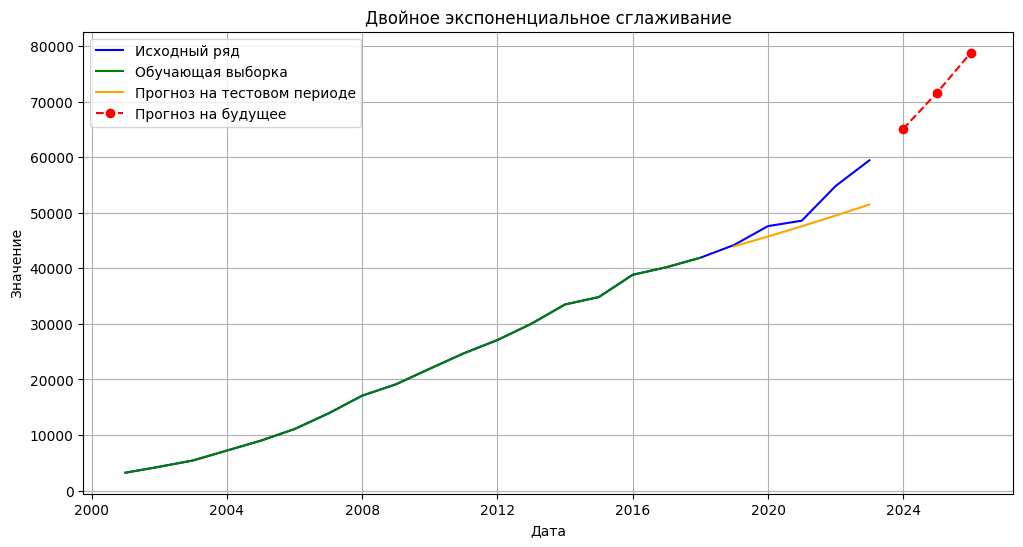

({'RMSE': 4386.443220733806,
  'MAE': 3280.284429229265,
  'MAPE': 5.9321861127423565},
 2023-12-31    65085.364953
 2024-12-31    71604.127943
 2025-12-31    78775.791487
 Freq: A-DEC, dtype: float64)

In [14]:
double_exponential_smoothing_pipeline(df, 'srd(cfo)', smoothing_level=0.7, smoothing_slope=0.9, train_size=0.8, future_periods=3)